오늘은, dlib의 face_detector 객체를 이용하여, 사람의 얼굴을 인식하여 고양이 수염을 그려보는 토이 프로젝트를 진행해보았습니다.

# 1. 합성할 이미지를 불러온 후, 얼굴인식하기

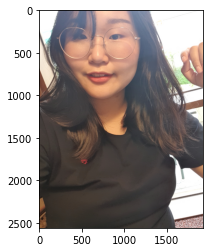

In [6]:
# 합성할 이미지 확인하는 코드
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

my_image_path=os.getenv('HOME')+'/aiffel/Aiffel_Exploration_nodes/camera_sticker/images/ME1.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


In [7]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)  

위 코드는 dlib의 face detector 객체를 생성해주고, 얼굴 인식을 시키는 코드입니다.
여기서 face detector는 HOG와 SVM을 사용해서 얼굴을 찾습니다.
HOG는 Histogram of Oriented Gradients를 의미하며 이미지에서 색상의 변화량을 나타내는 값입니다. 

detector_hog(img_rgb, 1)의 코드에서 첫번째 매개변수는 실제 이미지가 들어가고, 두번째 매개변수는 이미지 피라미드의 개수가 들어갑니다.
이미지 피라미드란, 간단하게는 데이터의 크기를 키우는 것이라고 할 수 있습니다. 이미지는 CNN의 레이어를 통과하면서 이미지 크기가 작아지는데 이것을 down sampling이라고 하고, 그 반대의 개념이 upsampling입니다. 이미지 피라미드는 이미지를 upsampling해주는 것입니다.

rectangles[[(191, 85) (1149, 1043)]]


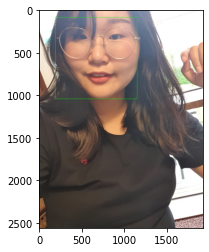

In [8]:
#인식한 얼굴 네모로 표시해주는 코드
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 2. 얼굴 이목구비 랜드마크하기

얼굴 이목구비를 랜드마크 하는 것은 Dlib에서 제공하는 pretrained model을 이용하였습니다. 해당 모델은 bz2압축 파일 형태로 제공되어 압축을 풀어서 사용했습니다.

In [9]:
model_path = os.getenv('HOME')+'/aiffel/Aiffel_Exploration_nodes/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [10]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


68


landmark_predictor는 rgb이미지와 dlib.rectangle을 입력을 받아 dlib.full_object_detection을 반환합니다.

dlib.full_object_detectin의 객체인 points를 parts함수로 개별 위치에 접근하였고, list_points라는 튜플에 개별 위치에 저장된 값을 x,y의 형태로 저장하였습니다. 

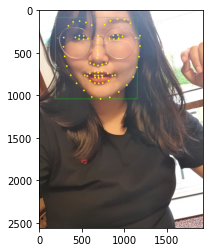

In [11]:
# 랜드마크된 곳 시각화

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3. 스티커 적용하기

스티커의 위치는 x=x_(nose), y= y_(nose) + (height/2)
스티커의 크기는 width = height = width_box로 하였습니다.

In [12]:
# 코의 중심점과, 스티커의 x,y 좌표, 크기를 표시하는 코드

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] + dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(680, 561)
(x,y) : (680,1040)
(w,h) : (959,959)


In [13]:
# 스티커 이미지 가져온 후, 위의 스티커 크기만큼 resize해줍니다.
sticker_path = os.getenv('HOME')+'/aiffel/Aiffel_Exploration_nodes/camera_sticker/images/CAT WHISKERS.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(959, 959, 3)


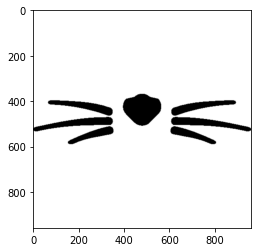

In [14]:
# 스티커 사진의 원본 출력
plt.imshow(img_sticker)
plt.show()

In [15]:
# 원본 이미지에 스티커 이미지를 추가하기 위해, x, y좌표를 조정합니다.
# 이미지의 시작점이 top-left이기 때문입니다.
refined_x = x - w //2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (201,81)


이때, y값이 음수가 나오는 것은 스티커가 사진의 위치를 벗어나는 것이기 때문에 음수에 대한 예외처리가 필요합니다.

In [16]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (201,81)


In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)


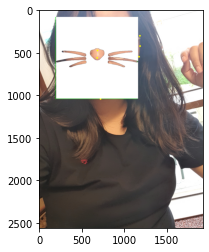

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

AIFFEL에서 배운 코드로 바로 해결되었다면 Exploration 노드가 아니었겠지 라는 생각이 드는 결과화면 입니다.ㅎ_ㅎ
그냥 딱 봐도 보이는 저 문제를 해결해 보려합니다.


# 4. 사진에 고양이 수염만 보이게 수정하기


이미지 데이터에서 픽셀은 0-255사이의 값을 가지고 검정색은 0 픽셀 값을, 하얀색은 255 픽셀 값을 가지고 있습니다.
그렇기 때문에 위에서 뽑아보았던 고양이 수염은 배경은 흰색 : 255 픽셀값, 수염부분은 검정색 : 0 픽셀 값 이었을것입니다. 그렇기 때문에, 기존의 사진과 합성을 하였을 때, 그저 픽셀끼리 연산을 했다면, 검정색은 픽셀값 +0이고, 흰색은 +255였을 것이므로, 합성된 저 결과가 고양이 코 부분은 기존 사진의 부분이 보이고, 배경부분은 하얗게 변했을거라 생각합니다.

저는 이 문제를 다음 링크를 참고해 수정하려했습니다.
https://sejin0134.tistory.com/47
openCV에서 두 이미지를 합성할 때 사용하는 bitwise 메소드를 이용하려고 뜯어 보던 중, 약간의 잔머리를 사용하기로 했습니다.^_^,, ~~익스 노드가 밀리지 않았다면 이런일은 없었겠,,,~~

어차피 사용하고 싶은 스티커 연산은 흑 / 백 데이터이므로, 그냥 스티커 이미지를 반전시켜주기로 했습니다 ^_^,,,, 이는 sticker img가 흑백 사진일때만 가능한 방법입니다. ~~나중엔 꼭 컬러이미지로도 가능하도록 수정해야지,,,,~~

## 4-1. 아이디어 1. 기존 수염 이미지 반전시키기

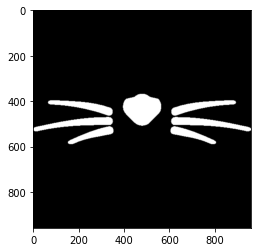

In [19]:
# 이미지 반전시키기.

reversed_img_sticker = cv2.bitwise_not(img_sticker)
plt.imshow(reversed_img_sticker)
plt.show()

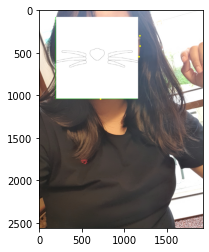

In [20]:
# reversed imge sticker로 다시 사진 합성 시도하기

sticker_area = img_show[refined_y:refined_y+reversed_img_sticker.shape[0], refined_x:refined_x+reversed_img_sticker.shape[1]]
img_show[refined_y:refined_y+reversed_img_sticker.shape[0], refined_x:refined_x+reversed_img_sticker.shape[1]] = \
    np.where(reversed_img_sticker==0,sticker_area,reversed_img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

안타깝게도, 고양이 수염부분이 전부, 0과 255로 이루어져있진 않았나 봅니다.
고양이 수염의 스케치선만 남고, 하얀색은 여전히 남아있습니다.

여기서 두가지를 확인할 수 있었습니다.
1. 고양이 수염 스티커가 0과 255 binary img는 아니었다.
2. 여전히 흰색 배경은 안없어진다.

저 문제를 해결하기 위해, 그림을 이진화도 해보고, openCV에서 이미지 두개를 알파값연산하는 코드도 작성해 보았으나, 문제는 저 문제가 아니었습니다. 알고보니, img_show의 변수를 복사할 때  np.array의 copy가 얕은 복사라서 처음 문제의 결과화면에 하얀색 수염이 덧그려진것이었습니다. ~~어쩐지 결과화면이 이해가 안되더라ㅠ~~

그래서 아래코드에서는 img_show를 깊은 복사로 새로 가져오고, 이미지를 반전시켜서 합성하면 수염이 하얗게 된다는 문제가 발생시켜 기존 그림에서 합성을 진행하기로 결정하였습니다.

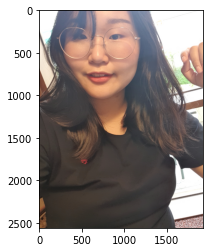

In [21]:
# test1_img 변수를 img_bgr의 깊은 복사로 사용.
my_image_path=os.getenv('HOME')+'/aiffel/Aiffel_Exploration_nodes/camera_sticker/images/ME1.jpg'
img_bgr = cv2.imread(my_image_path)
test1_img = np.zeros(img_bgr.size)
test1_img = img_bgr.copy()
test1_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(test1_img)
plt.show()


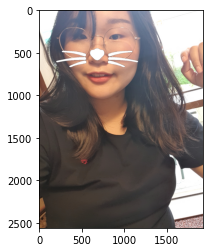

In [22]:
# test1_img 를 일부러 수정하여 깊은 복사가 이루어졌는지 확인.
sticker_area = test1_img[refined_y:refined_y+reversed_img_sticker.shape[0], refined_x:refined_x+reversed_img_sticker.shape[1]]
test1_img[refined_y:refined_y+reversed_img_sticker.shape[0], refined_x:refined_x+reversed_img_sticker.shape[1]] = \
    np.where(reversed_img_sticker==0,sticker_area,reversed_img_sticker).astype(np.uint8)

plt.imshow(test1_img)
plt.show()

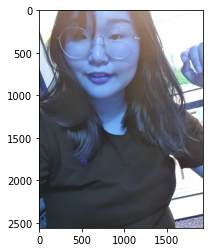

In [23]:
# img_bgr을 수정되지 않았으므로 deep copy가 이루어진것을 알 수 있다.
plt.imshow(img_bgr)
plt.show()

## 4.2 해결 코드

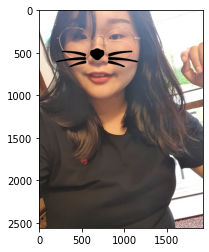

In [24]:
test2_img = np.zeros(img_bgr.size)
test2_img = img_bgr.copy()
test2_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

sticker_area = test2_img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
test2_img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker>250,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(test2_img)
plt.show()


# 5. 다른 사진에서 스티커 사진 적용해보기

68


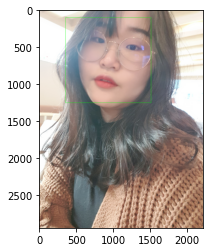

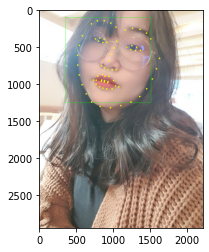

In [32]:
# 얼굴인식, face detection
my_image_path=os.getenv('HOME')+'/aiffel/Aiffel_Exploration_nodes/camera_sticker/images/ME3.jpg'
my_img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
my_img_show = my_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
my_img_show2 = my_img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

my_img_rgb = cv2.cvtColor(my_img_bgr, cv2.COLOR_BGR2RGB)

my_detector_hog = dlib.get_frontal_face_detector()
my_dlib_rects = my_detector_hog(my_img_rgb, 1)  

for dlib_rect in my_dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(my_img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

my_list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in my_dlib_rects:
    points = landmark_predictor(my_img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    my_list_landmarks.append(list_points)

print(len(my_list_landmarks[0]))

# 랜드마크된 곳 시각화
my_img_show_rgb = cv2.cvtColor(my_img_show, cv2.COLOR_BGR2RGB)

plt.imshow(my_img_show_rgb)
plt.show()

for landmark in my_list_landmarks:
    for point in landmark:
        cv2.circle(my_img_show, point, 10, (0, 255, 255), -1)

my_img_show_rgb = cv2.cvtColor(my_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(my_img_show_rgb)
plt.show()

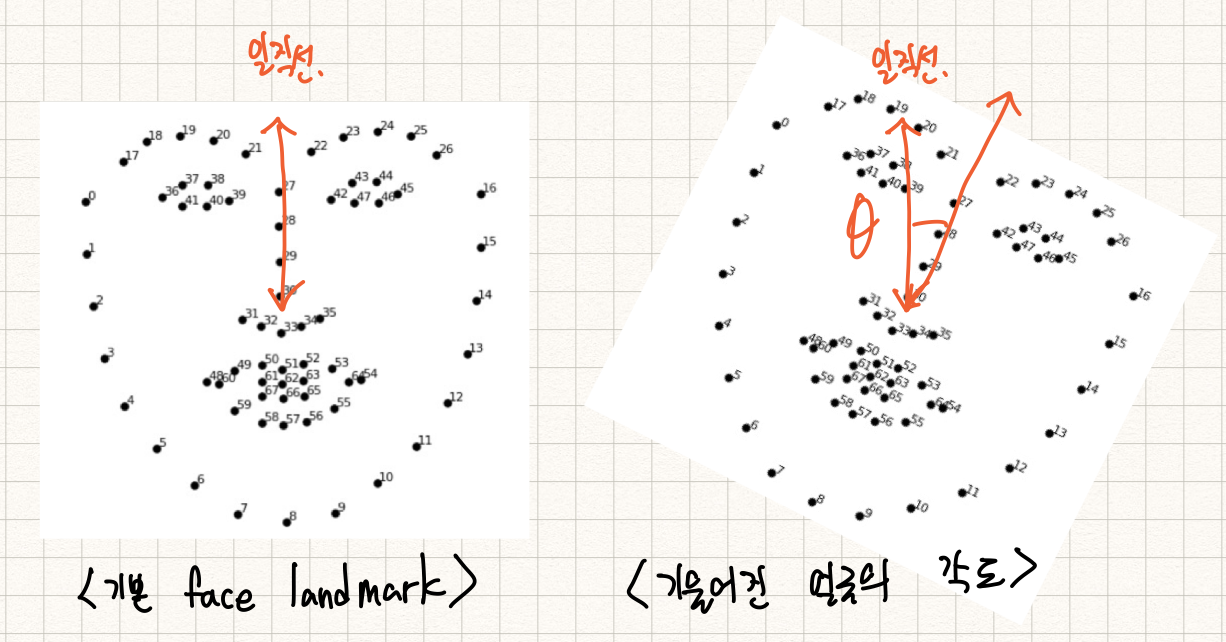

저는 고개가 틀어진 각도를 계산하여, 해당 각도만큼 스티커를 돌려주는 방법으로 각도를 맞춰주기로 하였습니다.

face landmark의 30번째인덱스와 27번째 인덱스가 직선을 이루는 것을 이용하여, 30번인덱스에서 위쪽으로 수직인 점을 하나찍고, 그 점과, 30번 인덱스, 27번 인덱스가 이루어 내는 각으로 얼굴이 기울어진 각을 구하였습니다.

각도를 구하는 코드는 다음 링크를 참고하였습니다.
https://pythonq.com/so/python/1717141

In [33]:
# 27번과 30번 인덱스를 이용하여, 기울어진 각도 구하는 코드

print(my_list_landmarks[0][30])
print(my_list_landmarks[0][27])

origin=np.array([my_list_landmarks[0][30][0],my_list_landmarks[0][30][1]])
point2=np.array([my_list_landmarks[0][30][0], my_list_landmarks[0][30][1]-100])
point1=np.array([my_list_landmarks[0][27][0],my_list_landmarks[0][27][1]])

def getAngle(origin, point1, point2):
    ba = point1-origin
    bc = point2-origin

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle) 
    pAngle = np.degrees(angle)
    
    return pAngle
        
angle = getAngle(origin, point1, point2)
print(angle)

(943, 685)
(1046, 421)
21.31331832265606


(1152, 1152, 3)


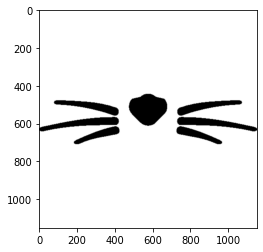

before 1152 1152
before 576 576


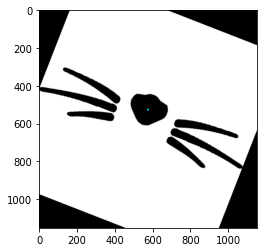

after 1152 1152
after 576 576


In [36]:
sticker_path = os.getenv('HOME')+'/aiffel/Aiffel_Exploration_nodes/camera_sticker/images/CAT WHISKERS.png'
my_img_sticker = cv2.imread(sticker_path)
my_img_sticker = cv2.resize(my_img_sticker, (w,h))
print (my_img_sticker.shape)  

# 스티커를 돌려주었습니다.

(h, w) = my_img_sticker.shape[:2]
(cX, cY) = (w // 2, h // 2)

# 원본이미지
plt.imshow(my_img_sticker)
plt.show()
print("before", h, w)
print("before", cX,cY)

cv2.circle(my_img_sticker, [cX,cY-50], 5,(0,255,255),-1)

# 회전의 중심을 스티커 사진의 정 중앙이 아니라,
# 고양이 코의 중심이 되도록 회전 중심을 설정해주었습니다.

M = cv2.getRotationMatrix2D((cX, cY-50), -21.31, 1.0)
rotated = cv2.warpAffine(my_img_sticker, M, (w, h))

(h, w) = rotated.shape[:2]
(cX, cY) = (w // 2, h // 2)

plt.imshow(rotated)
plt.show()
print("after", h, w)
print("after", cX,cY)

In [37]:
# 코의 중심점과, 스티커의 x,y 좌표, 크기를 표시하는 코드

for dlib_rect, landmark in zip(my_dlib_rects, my_list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] + dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(943, 685)
(x,y) : (943,1260)
(w,h) : (1152,1152)


In [38]:
print(x,y)

943 1260


(x,y) : (367,108)


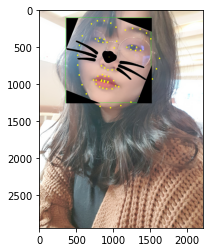

In [39]:
refined_x = x - w //2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

rotated_sticker_area = my_img_show[refined_y:refined_y+rotated.shape[0], refined_x:refined_x+rotated.shape[1]]
my_img_show[refined_y:refined_y+rotated.shape[0], refined_x:refined_x+rotated.shape[1]] = \
    np.where(rotated>250,rotated_sticker_area,rotated).astype(np.uint8)

#my_sticker_area = my_img_show[refined_y:refined_y+my_img_sticker.shape[0], refined_x:refined_x+my_img_sticker.shape[1]]
#my_img_show[refined_y:refined_y+my_img_sticker.shape[0], refined_x:refined_x+my_img_sticker.shape[1]] = \
#    np.where(img_sticker>250,my_sticker_area,my_img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(my_img_show, cv2.COLOR_BGR2RGB))
plt.show()


스티커 이미지를 돌리면서 만들어진 빈공간은 0bit로 채워지게 됩니다. 그렇기 때문에, 스티커에 대한 후처리를 해주지 않으면 위와 같이 테두리가 생기게 됩니다.

처음에는 다음과 같은 수학적 사실을 이용하여 문제를 해결하려 하였습니다.
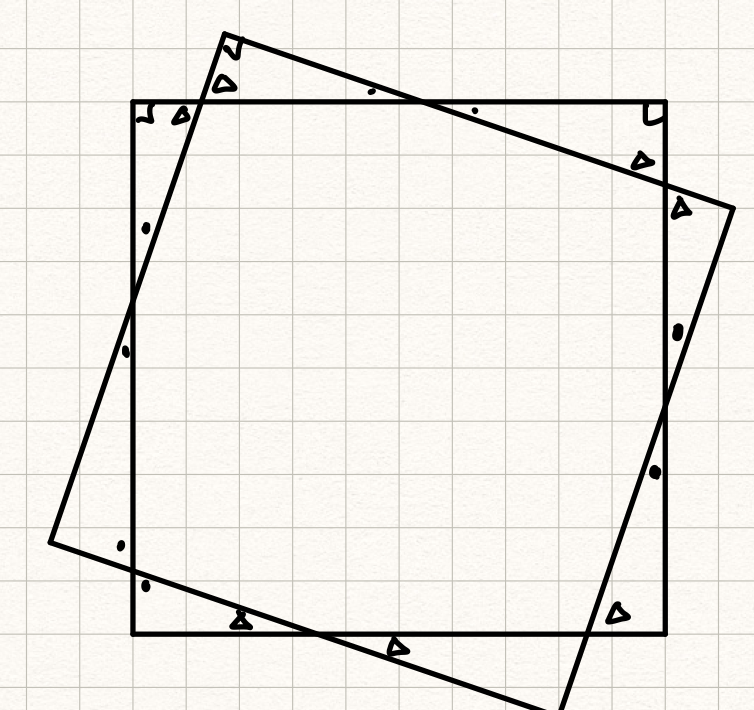

두개의 곂쳐진 사각형에서 하나의 사각형을 사각형의 중심을 기준으로 회전하면 동일한 삼각형 4개의 부분이 생기게 됩니다. 이 정보를 이용하면, cos과 sin을 이용하면 x좌표와 y좌표마다 if 문으로 삼각형범위를 알수있게 됩니다. 그럼 그 해당 범위의 픽셀값을 255로 맞춰주면 문제가 해결됩니다.

하지만 저는, 사진을 사각형의 중심이 아니라, 고양이코를 중심으로 돌렸기 때문에, 저 이론을 바로 쓰기에는 무리가 있고, ~~수학적으로 풀고싶지 않았,,.~~ 계산해 내는 방법보다, 연산은 많이 하겠지만 직관적으로 이해하기 쉬운 방법을 택했습니다.

바로, 스티커사진에서 고양이 코 수염부분을 다른색깔로 잠시 치환하는 것입니다.
치환한 후, 스티커 사진을 돌리고, 검정색인 부분을 전부 하얀색으로 변경해줍니다.
그리고 그 사진의 결과에서 다시 치환된 색상을 돌려주면 해결이 됩니다.

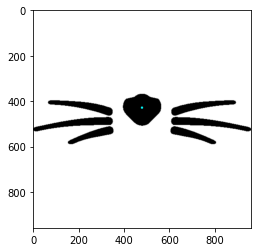

In [31]:
# 기존 스티커 이미지 출력
plt.imshow(my_img_sticker)
plt.show()

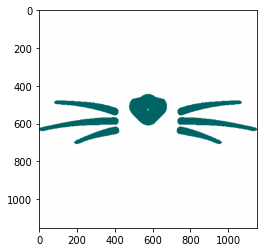

In [72]:
# 기존의 이미지에서 색이 0인 곳을 [0,100,100]의 색상으로 치환하였습니다.
test_img = np.zeros(my_img_sticker.size,np.uint8)
test_img = my_img_sticker.copy()
test_img =np.where(test_img==0,[0,100,100],254)
plt.imshow(test_img)
plt.show()


(1152, 1152, 3)
(1152, 1152, 3)


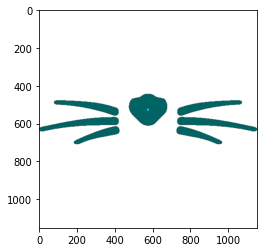

before 1152 1152
before 576 576


error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/imgproc/src/imgwarp.cpp:1800: error: (-215:Assertion failed) ifunc != 0 in function 'remap'


In [68]:
# 색 치환한 스티커 회전
(h, w) = test_img.shape[:2]
(cX, cY) = (w // 2, h // 2)

print(my_img_sticker.shape)
print(test_img.shape)

# 원본이미지
plt.imshow(test_img)
plt.show()
print("before", h, w)
print("before", cX,cY)

# 회전의 중심을 스티커 사진의 정 중앙이 아니라,
# 고양이 코의 중심이 되도록 회전 중심을 설정해주었습니다.

M = cv2.getRotationMatrix2D((cX, cY-50), -21.31, 1.0)
test_rotated = cv2.warpAffine(test_img, M, (w, h))

(h, w) = test_rotated.shape[:2]
(cX, cY) = (w // 2, h // 2)

plt.imshow(test_rotated)
plt.show()
print("after", h, w)
print("after", cX,cY)

색치환까진 했으나, 해당 오류를 해결하진 못하였습니다.ㅠㅠ

numpy배열이 openCV에서 사용이 안되어 오류가 뜨는건가 싶어서 ~~, copy해줬는데 왜 안되는지 부터 납득이 안되지만~~cv.fromarray/Image.fromarray 메소드도 찾아보고 stackoverflow를 열심히 뒤져봤지만 딱맞는 솔루션을 발견하지 못하여 여기까지 한 후, 마무리 지었습니다. 저 문제를 꼭 해결하거나, 수학적 계산을 통하여 해당 문제를 꼭 해결해내고싶습니다.